<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/ctf_aliasing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
* investigate rapidly oscilating CTF and the aliasing effects this can cause

# Resources
* Penczek, P. A., & et al. (2014). CTER—Rapid estimation of CTF parameters with error assessment. Ultramicroscopy. http://doi.org/10.1016/j.ultramic.2014.01.009

* https://github.com/cryoem/eman2/blob/master/sparx/libpy/morphology.py

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# CTF (1D)

In [108]:
voltage = 300 # in kev
lam = 12.398/np.sqrt(voltage*(1022.0+voltage))  #  All units in A
Cs = 2
defocus = 4
pix=1.5 # in A
nx=256

cis = Cs*1.e7 # mm
A = 0.5*defocus*10000.0*lam # defocus in um
B = 0.25*cis*lam*lam*lam

In [91]:
def ctf_1d(defocus, Cs, lam, nx,pix):
  freq = np.arange(start=0,stop=1/(2*pix),step=1/(nx*pix))
  cis = Cs*1.e7 # mm
  A = 0.5*defocus*10000.0*lam # defocus in um
  B = 0.25*cis*lam*lam*lam
  f2 = freq*freq
  gamma = 2*np.pi*(-A*f2+B*f2*f2)
  return(np.sin(gamma), freq)



(128,)

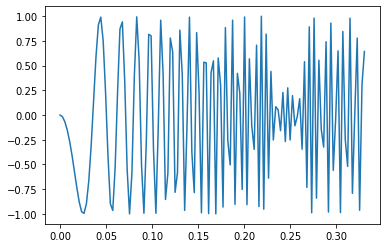

In [155]:
ctf,freq = ctf_1d(defocus, Cs, lam, nx=nx,pix=pix)
sr = pd.Series(ctf)
sr.index = freq
sr.plot()
ctf.shape

## CTF dependence on particle box size and pixel size

The CTF is the same, but goes out more to higher resolution when we adjust the number of pixels and the pixel size by $(n_x,p) \rightarrow (n_xf,p/f)$

(1281,)

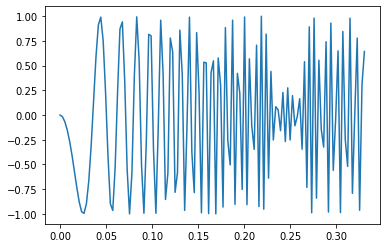

In [162]:
factor=10
ctf,freq = ctf_1d(defocus, Cs, lam, nx=nx*factor,pix=pix/factor)
sr = pd.Series(ctf[:nx//2]) # with factor=1 this is the whole domain, but with larger factor goes out more
sr.index = freq[:nx//2]
sr.plot()
ctf.shape

# CTF aliasing

The period of the CTF gets smaller at increasing spatial frequency, and satisfies this equation (Eq 10 in Penczek et al, 2015)

$$\frac{1}{2} \Delta z \lambda s_0^2+\frac{1}{4}\lambda^3 s_0^4 = \frac{1}{2}\Delta z \lambda(s_0+T)^2+\frac{1}{4}\lambda^3(s_0+T)^4$$

The T that satisfies this equation depends on $s_0$, so we can find the highest s_0 at which T is still larger than two Fourier pixels ($T_{grid} = \frac{2}{n_xp}$) fixed from our discritization

In [111]:
def ctfperiod(defocus, Cs, lam, freq):
  # find local "period" T by solving fourth order polynomial resulting from equation:
  #  sin( 2pi (gamma(freq) + 1) ) = sin( 2pi (gamma(freq+T) )
  cis = Cs*1.e7 # mm
  A = 0.5*defocus*10000.0*lam # defocus in um
  B = 0.25*cis*lam*lam*lam
  f2 = freq*freq
  """
  for i in xrange(800):
    ff = freq+(i-400)*0.00002
    print  ff,Util.tf(defocus, ff, voltage, Cs, 10., 0.0, 1.0)
  """
  rot = np.roots([B, 4*B*freq, 6*B*f2-A, 4*B*f2*freq-2*A*freq, -1.0])
  #print np.roots([A,2*A*freq,1.0]),-freq-np.sqrt(f2/2-1./A),-freq+np.sqrt(f2-1./A)
  #print  Util.tf(defocus, freq, voltage, Cs, 10., 0.0, 1.0),Util.tf(defocus, freq+min(rot), voltage, Cs, 10., 0.0, 1.0)
  return rot # min(abs(rot))

In [115]:
f = .25
rot = ctfperiod(defocus, Cs, lam, freq=f)
rot

array([-3.45324476,  2.95324476, -0.49480551, -0.00519449])

In [116]:
T_grid = 2/(nx*pix)
T_grid


0.005208333333333333

In [117]:
T = np.abs(rot[np.isreal(rot)]).min()
T > T_grid, T, T_grid

(False, 0.005194489027024809, 0.005208333333333333)

Above we see that for a fixed $s_0$, we have the LHS=RHS of Eq 10 at T, which is given by `ctfperiod`, with care taken for real vs imaginary roots, and the absolute value.

$T_{grid} = \frac{2}{n_xp}$, and so if $|T| > |T_{grid}|$, there is not aliasing at this $s_0$, because the local period is larger than two Fourier pixels.

However, if the local period is smaller than two Fourier pixels, then there are aliasing issues.

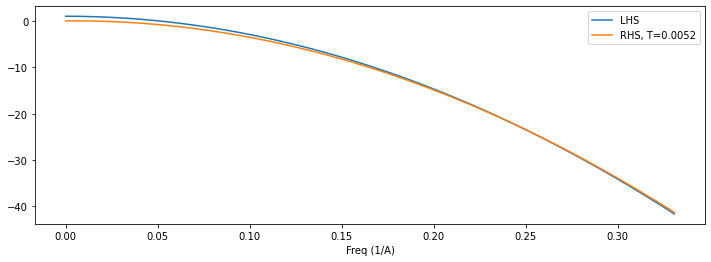

In [118]:
ctf,freq = ctf_1d(defocus, Cs, lam, nx=nx,pix=pix)
f2 = freq*freq

fT2 = (freq-T)**2 # note the sign! look at rot to see
LHS = (-A*f2+B*f2*f2) + 1
RHS = (-A*fT2+B*fT2*fT2)

fig,axes = plt.subplots(nrows=1,figsize=(12,4))

sr = pd.Series(LHS)
sr.index = freq
sr.plot(ax=axes,label='LHS',legend=True)
axes.set_xlabel('Freq (1/A)')

sr = pd.Series(RHS)
sr.index = freq
sr.plot(ax=axes,label='RHS, T=%.4f'%T,legend=True)

# Finding the frequency cutoff for CTF aliasing

Now that we know how to see if there is aliasing at a certain frequency, we can check all frequencies and find the maximal frequency where the CTF aliasing starts to cause problems.

This introduces a limit on resolution.

In [123]:
f_aliasing = np.inf
T_aliasing = None
for f in freq:
  rot = ctfperiod(defocus, Cs, lam, freq=f)
  T = np.abs(rot[np.isreal(rot)]).min()
  if T < T_grid:
    print('CTF aliasing at freq %.2f (%.1f A) because CTF period is %.4f'%(f,1/f,T))
    if f < f_aliasing: 
      f_aliasing = f
      T_aliasing = T

CTF aliasing at freq 0.25 (4.0 A) because CTF period is 0.0052
CTF aliasing at freq 0.25 (4.0 A) because CTF period is 0.0051
CTF aliasing at freq 0.26 (3.9 A) because CTF period is 0.0051
CTF aliasing at freq 0.26 (3.9 A) because CTF period is 0.0050
CTF aliasing at freq 0.26 (3.8 A) because CTF period is 0.0050
CTF aliasing at freq 0.26 (3.8 A) because CTF period is 0.0049
CTF aliasing at freq 0.27 (3.8 A) because CTF period is 0.0049
CTF aliasing at freq 0.27 (3.7 A) because CTF period is 0.0048
CTF aliasing at freq 0.27 (3.7 A) because CTF period is 0.0048
CTF aliasing at freq 0.27 (3.7 A) because CTF period is 0.0048
CTF aliasing at freq 0.28 (3.6 A) because CTF period is 0.0047
CTF aliasing at freq 0.28 (3.6 A) because CTF period is 0.0047
CTF aliasing at freq 0.28 (3.6 A) because CTF period is 0.0046
CTF aliasing at freq 0.28 (3.5 A) because CTF period is 0.0046
CTF aliasing at freq 0.29 (3.5 A) because CTF period is 0.0045
CTF aliasing at freq 0.29 (3.5 A) because CTF period is

Visually, the 1D CTF has starts to do "funny things" before the predicted aliasing threshold. This may be because a CTF that is oscilating up and down over two Fourier pixels looks "funny", while it still passes the threshold for aliasing artefacts.

Text(0, 0.5, 'CTF')

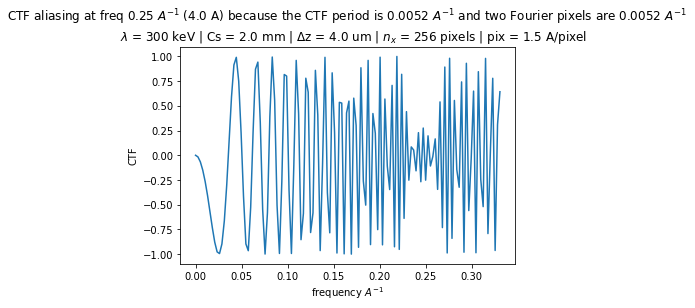

In [149]:
ctf,freq = ctf_1d(defocus, Cs, lam, nx=nx,pix=pix)
sr = pd.Series(ctf)
sr.index = freq
sr.plot()
ctf.shape
plt.title('CTF aliasing at freq %.2f $A^{-1}$ (%.1f A) because the CTF period is %.4f $A^{-1}$ and two Fourier pixels are %.4f $A^{-1}$ \n \
  $\lambda$ = %i keV | Cs = %.1f mm | $\Delta$z = %.1f um | $n_x$ = %i pixels | pix = %.1f A/pixel'\
  %(f_aliasing,1/f_aliasing,T_aliasing,T_grid,voltage,Cs,defocus,nx,pix))
plt.xlabel('frequency $A^{-1}$')
plt.ylabel('CTF')

The above plot has pretty reasonable microscope data collection values (voltage, Cs, defocus, box size, pixel size). Yet there is clearly CTF aliasing. Thus CTF aliasing is definitely something to watch out for. The good news is that if we keep a look out for CTF aliasing in 1D plots of the analytic form of the CTF (with no envelope applied), we are likely to spot it because of "funny" dampning and then expanding of the amplitude, or phase shift.

... I wonder how much it is happening without people realizing it... especially when a small box size is chosen, and the defocus is on the high side.

# Take Homes

To avoid these aliasing artefacts
* take a larger box size or a larger pixel size. This decreases $T_{grid}$ (e.g. 350 pixels vs 256 pixels), the latter will also include delocalized spatial frequency information
* have lower defocus. This makes the CTF oscilate less rapidly at a given spatial frequency (e.g. 1-2 vs 3-4 um)
* (not 100% sure about this one:) when applying the CTF, temporarily up sample in Fourier space (don't collect the data at larger pixel sizes of larger box sizes, but just upsample with the data you have when applying the CTF)